# Setup

Importing the relevant packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
import nvsmi

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth


In [2]:
def setup_tensorflow(seed=None):
    try:
        import nvsmi

        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)

In [3]:
setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-05-04 19:57:07.556318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

## Reproducibility

The following cell contains the seed use to generate reproducible random realizations of BTK output. Using the same seed in BTK for **both the sampling function and draw blend generator** (more info below) guarantees the galaxy images and parameters produced will be the same, even across different systems.

In [5]:
from btk import DEFAULT_SEED
seed = DEFAULT_SEED
save_path = "output/blends"


COSMOS_CATALOG_PATHS = [
    "data/cosmos/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "data/cosmos/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]

Every object in BTK that needs a seed uses `DEFAULT_SEED` implicitly. In this tutorial we explicitly show how this seed is passed in and which objects needs a seed. However, we omit it in the other tutorials.

# Draw some blends

We will first explore the image generation part of BTK. We need to provide 3 main elements: the catalog, a sampling function and a survey.

## Catalog

BTK uses a wrapper class for the actual catalog object, to get a standardized input for the generator. Currently BTK supports two kind of catalogs: Catsim-like catalogs and the COSMOS catalog (as provided with Galsim). Both have their own implementation of the `Catalog` class; we will only use the Catsim one here. You can easily import the catalog from a FITS file using the `from_file` method as demonstrated here with our example catalog.

In [6]:
catalog_name = "data/cosmos/real_galaxy_catalog_23.5_example.fits"
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS, exclusion_level="none" )

It is also possible to instantiate the class by giving it the catalog directly; the `from_file` method is merely a shortcut.

In [7]:
#_, ext = os.path.splitext(catalog_name)
#fmt = "fits" if ext.lower() == ".fits" else "ascii.basic"
#raw_catalog = astropy.table.Table.read(catalog_name, format=fmt)
#catalog = btk.catalog.CosmosCatalog(raw_catalog)

When the Catalog object is created, it creates internally a `table` attribute containing a modified table from the input, which will be used in the rest of the code.

## Sampling function

The sampling function is an object which is used to determine the informations about the blends, eg which galaxies are drawn, with what shifts, ... This is achieved using the `SamplingFunction` class, which is callable like a function, taking as argument the `Catalog.table` and returning modified selected entries corresponding to the galaxies being drawn. For this tutorial, we will use the default sampling function, which can be instantiated like this:

In [8]:
stamp_size = 12.8  # Size of the stamp, in arcseconds
max_number = 2     # Maximum number of galaxies in a blend
max_shift = 3    # Maximum shift of the galaxies, in arcseconds
 # random seed is used here!

As a reference, here is a (slightly) simplified version of the code for this sampling function

In [9]:

class DefaultSampling1(btk.sampling_functions.SamplingFunction):
    """Default sampling function used for producing blend tables."""

    def __init__(self, stamp_size=12.8, maxshift= 3):
        """
        Args:
            max_number (int): Defined in parent class
            stamp_size (float): Size of the desired stamp.
            maxshift (float): Magnitude of maximum value of shift. If None then it
                             is set as one-tenth the stamp size. (in arcseconds)
        """
        super().__init__(2)
        self.stamp_size = stamp_size
        self.maxshift = maxshift if maxshift else self.stamp_size / 10.0
        
    @property
    def compatible_catalogs(self):
        return "CatsimCatalog", "CosmosCatalog"

    def __call__(self, table):
        """Applies default sampling to the input CatSim-like catalog and returns an
        astropy table with entries corresponding to a blend centered close to postage
        stamp center.

        Function selects entries from input table that are brighter than 25.3 mag
        in the i band. Number of objects per blend is set at a random integer
        between 1 and Args.max_number. The blend table is then randomly sampled
        entries from the table after selection cuts. The centers are randomly
        distributed within 1/10th of the stamp size. Here even though the galaxies
        are sampled from a CatSim catalog, their spatial location are not
        representative of real blends.

        Args:
            table (astropy.table): Table containing entries corresponding to galaxies
                                   from which to sample.

        Returns:
            Astropy.table with entries corresponding to one blend.
        """
        (q1,) = np.where(table["ref_mag"] <= 24.3)
        (q2,) = np.where(table["ref_mag"] <= 24.3)
        
        indexes1 = [np.random.choice(q1,), np.random.choice(q2,)]
        
        blend_table = table[indexes1]
        
        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0
        x_peak, y_peak = _get_random_center_shift(1, self.maxshift)
        blend_table["ra"][1] += x_peak
        blend_table["dec"][1] += y_peak

        if np.any(blend_table["ra"] > self.stamp_size / 2.0) or np.any(
            blend_table["dec"] > self.stamp_size / 2.0
        ):
            warnings.warn("Object center lies outside the stamp")
        return blend_table

def _get_random_center_shift(num_objects, maxshift):
    """Returns random shifts in x and y coordinates between + and - max-shift in arcseconds.

    Args:
        num_objects (int): Number of x and y shifts to return.

    Returns:
        x_peak (float): random shift along the x axis
        y_peak (float): random shift along the x axis
    """
    x_peak = np.random.uniform(-maxshift, maxshift, size=num_objects)
    y_peak = np.random.uniform(-maxshift, maxshift, size=num_objects)
    return x_peak, y_peak

You can see that this function chooses random galaxies (after applying a magnitude cut), computes random shifts for the galaxies and returns the entries from the table, adding two columns corresponding to the shifts. You may write more complex sampling functions if you wish to have more control over how the galaxies are drawn; there are some other examples in the `btk.sampling_functions` file. If you want to write your own, please check the `advanced-features` notebook, which will show what to do in more details.

## Survey

The BTK Survey object defines the observing conditions relative to a survey. It is based on the named tuple class, and contains various parameters (eg. pixel scale, effective_area), including a list of Filter objects. The Filter class is also a named tuple, and contains information concerning a specific filter in the survey (eg. exporesure time, psf). Numerous surveys are already implemented in BTK; we will import the Rubin one for this tutorial.

In [10]:
Rubin = btk.survey.get_surveys("Rubin")

/home/ppymn2/miniconda3/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


You may want to define your own survey if you wish to modify some parameters or use a survey which is not implemented in BTK. We advise you to take the code of an existing survey and modify it to your convenience. Here is the one for Rubin:

In [11]:
from btk.survey import get_psf
_central_wavelength = {
    "u": 3592.13,
    "g": 4789.98,
    "r": 6199.52,
    "i": 7528.51,
    "z": 8689.83,
    "y": 9674.05,
}
Rubin = btk.survey.Survey(
    "Rubin",
    pixel_scale=0.2,
    effective_area=32.4,
    mirror_diameter=8.36,
    airmass=1.2,
    zeropoint_airmass=1.2,
    filters=[
        btk.survey.Filter(
            name="u",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["u"],
                fwhm=0.859,
            ),
            sky_brightness=22.9,
            exp_time=1680,
            zeropoint=26.40,
            extinction=0.451,
        ),
        btk.survey.Filter(
            name="g",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["g"],
                fwhm=0.814,
            ),
            sky_brightness=22.3,
            exp_time=2400,
            zeropoint=28.26,
            extinction=0.163,
        ),
        btk.survey.Filter(
            name="r",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["r"],
                fwhm=0.781,
            ),
            sky_brightness=21.2,
            exp_time=5520,
            zeropoint=28.10,
            extinction=0.10,
        ),
        btk.survey.Filter(
            name="i",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["i"],
                fwhm=0.748,
            ),
            sky_brightness=20.5,
            exp_time=5520,
            zeropoint=27.78,
            extinction=0.07,
        ),
        btk.survey.Filter(
            name="z",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["z"],
                fwhm=0.725,
            ),
            sky_brightness=19.6,
            exp_time=4800,
            zeropoint=27.39,
            extinction=0.043,
        ),
        btk.survey.Filter(
            name="y",
            psf=get_psf(
                mirror_diameter=8.36,
                effective_area=32.4,
                filt_wavelength=_central_wavelength["y"],
                fwhm=0.703,
            ),
            sky_brightness=18.6,
            exp_time=4800,
            zeropoint=26.56,
            extinction=0.138,
        ),
    ],
)

Most attributes should be pretty straightforward to modify; please take a look at the [API](https://lsstdesc.org/BlendingToolKit/src/btk.survey.html) for a more substantial description of the attributes. The [custom tutorial](https://github.com/LSSTDESC/BlendingToolKit/blob/main/notebooks/02b-custom-tutorial.ipynb) also provides descriptions of the attributes and more information on how to customize surveys.

The `psf` attribute deserves an additionnal explanation: it corresponds to the PSF for each filter. It can be provided either directly as a Galsim model e.g. `galsim.Kolmogorov(fwhm=1.5)` or as a function returning a Galsim model, for randomization purposes. For example:

In [12]:
def random_psf():
    fwhm = np.random.uniform(1.5,1.7)
    return galsim.Kolmogorov(fwhm=0.65)

You may want to use a function taking an argument to avoid rewriting the function for each filter; we advise using lambda functions to achieve this, eg `get_u_psf = lambda : get_custom_psf(u_band_argument)`.

Finally, you can use the default function `get_psf` as demonstrated in the Rubin Survey, to get a complex (not random) PSF, or use the function `get_psf_from_file(psf_dir, pixel_scale)` to import a PSF from a FITS file (randomly if there are more than one file in the directory provided).

You can find more on how to define your own survey, including details on all the arguments, in the `advanced-features` tutorial notebook.

## Drawing the blends

Now that we have all the objects at our disposal, we can create the DrawBlendsGenerator. This object is a python generator, meaning it can be called with `next(generator)` to generate a new batch. It is again declined for Catsim and COSMOS, and we will use the Catsim one here. We suggest you refer to the documentation for information on the additionnal parameters here.

In [13]:
sampling_function = DefaultSampling1()

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    Rubin,
    batch_size=10,
    stamp_size=12.8,
    cpus=1,
    add_noise="all",
    #save_path=save_path,
    seed=seed, # same random seed is used here too!
)

The results from the `next` call are stored in the dictionnary; the keys are:
- `blend_images` for the actual images (as a (batch_size,stamp_size,stamp_size,len(survey.filters))-sized numpy array )
- `isolated_images` for the isolated images (as a (batch_size,sampling_function.max_number,stamp_size,stamp_size,len(survey.filters))-sized numpy array )
- `blend_list` for the blend information (as a list of astropy tables corresponding to the output of the sampling function for each blend)
- `psf` for the PSF (as a list of Galsim objects)
- `wcs` for the World Coordinate System corresponding to the images (as a list of astropy.wcs.WCS objects)

Please note that several surveys can be provided as a list to the generator. In that case, each of the entry will contain a dictionnary indexed by the surveys, which in turn contains the results described as above (you would access it with `batch['blend_images']['LSST']` for instance.

Generating blends for Rubin survey:   0%|          | 0/10 [00:00<?, ?it/s]

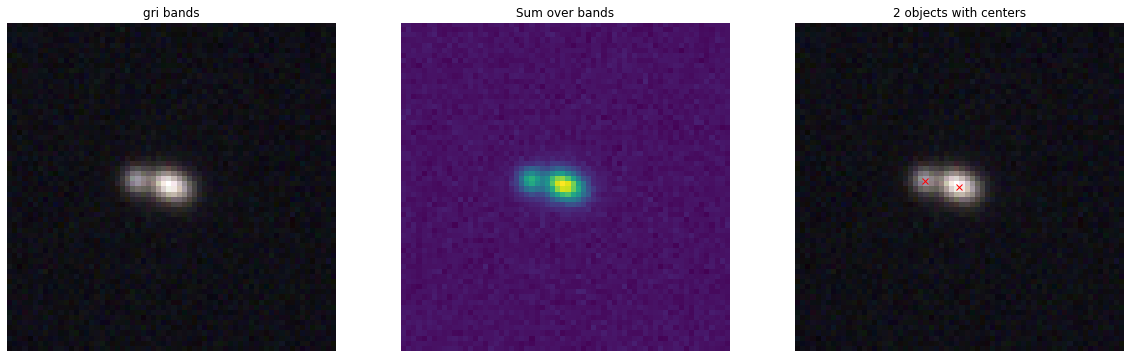

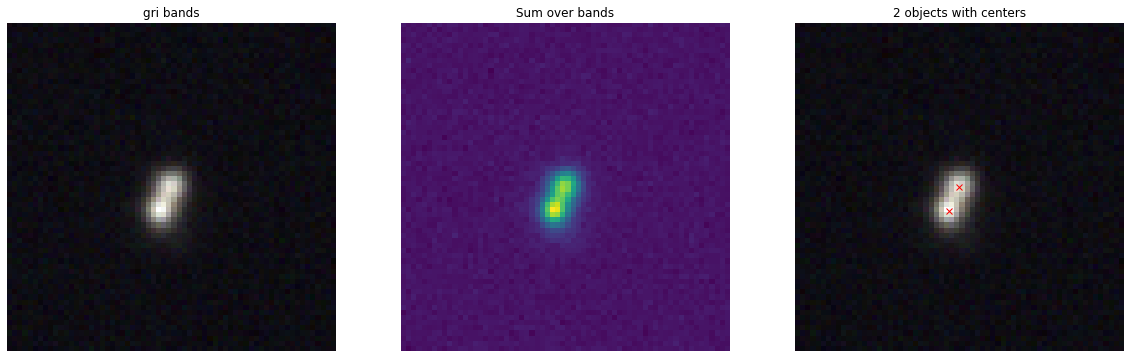

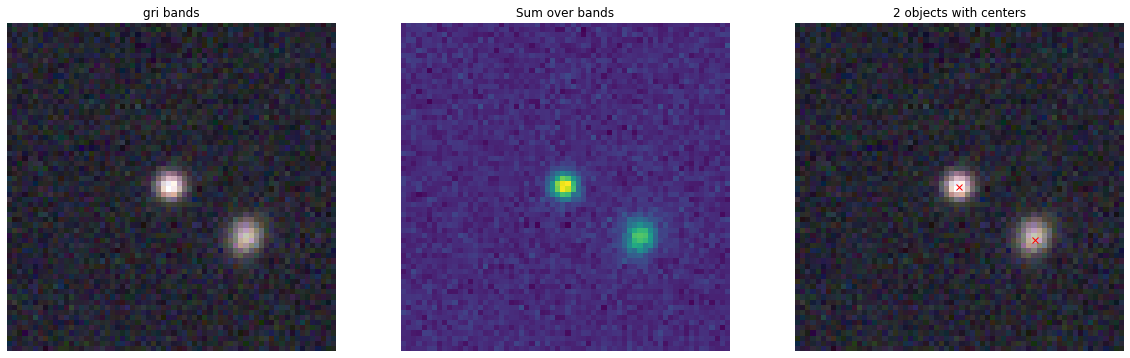

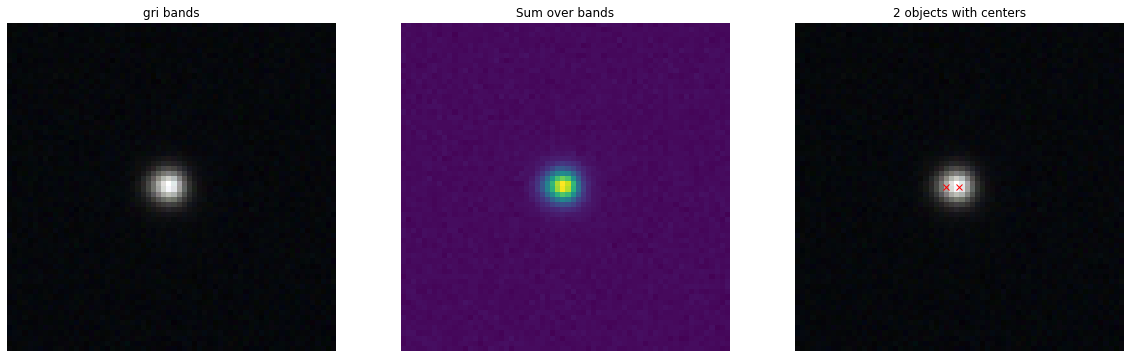

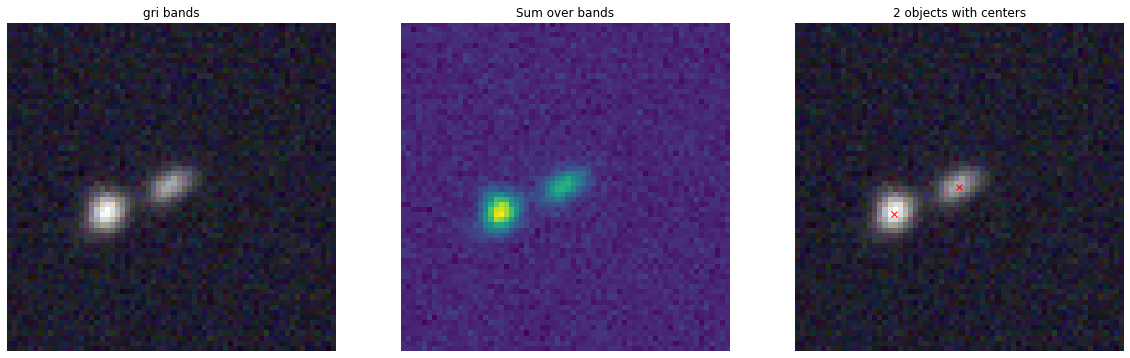

In [15]:
batch = next(draw_generator)

isolated_images = batch['isolated_images']
blend_images = batch['blend_images']
blend_list = batch['blend_list']
btk.plot_utils.plot_blends(blend_images[:5], blend_list[:5])



In [16]:
#If you want to sum over bands use this code:
"""
#Need to sum over the bands 
ngals = blend_images.shape[0]
all_bands_blends = np.zeros((ngals, 64, 64))
all_bands_components = np.zeros((2, ngals, 64, 64))
for i in range(ngals):
    all_bands_blends[i] = np.sum(blend_images[i, :, :, :], axis = 0)
    all_bands_components[0, i] = np.sum(isolated_images[i, 0, :, :, :], axis = 0) 
    all_bands_components[1, i] = np.sum(isolated_images[i, 1, :, :, :], axis = 0) 
"""

'\n#Need to sum over the bands \nngals = blend_images.shape[0]\nall_bands_blends = np.zeros((ngals, 64, 64))\nall_bands_components = np.zeros((2, ngals, 64, 64))\nfor i in range(ngals):\n    all_bands_blends[i] = np.sum(blend_images[i, :, :, :], axis = 0)\n    all_bands_components[0, i] = np.sum(isolated_images[i, 0, :, :, :], axis = 0) \n    all_bands_components[1, i] = np.sum(isolated_images[i, 1, :, :, :], axis = 0) \n'

In [17]:
#isolated_images.shape, all_bands_components.shape

In [18]:
#blend_images.shape, all_bands_blends.shape

In [19]:
"""

fig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))
for i in range(5):
    j = i + 3
    ax[0, i].imshow(all_bands_blends[j], origin='lower', interpolation='nearest')
    ax[1, i].imshow(all_bands_components[0, j], origin='lower', interpolation='nearest')
    ax[2, i].imshow(all_bands_components[1, j], origin='lower', interpolation='nearest')
    
"""

"\n\nfig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))\nfor i in range(5):\n    j = i + 3\n    ax[0, i].imshow(all_bands_blends[j], origin='lower', interpolation='nearest')\n    ax[1, i].imshow(all_bands_components[0, j], origin='lower', interpolation='nearest')\n    ax[2, i].imshow(all_bands_components[1, j], origin='lower', interpolation='nearest')\n    \n"

In [20]:
np.save("BTKblends.npy", blend_images)
np.save("BTKcomponents.npy", isolated_images)